In [1]:
import ast
import pandas as pd
import numpy as np
import os
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence 
from torch.nn.functional import pad
from tqdm import tqdm
import torch.nn.utils.rnn as rnn_utils
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [2]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
print("Torch version:", torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("Is ROCm available:", torch.version.hip is not None)

Torch version: 2.3.0+rocm6.2.3
Is CUDA available: True
CUDA device name: AMD Radeon RX 7900 XTX
Is ROCm available: True


<h4> Twitter 15 </h4>

In [3]:
# Loading source
Tw15_source = pd.read_csv(
    '/home/gigli/FakeNewsDetection/Twitter15-16/twitter15/source_tweets.txt',  # Adjust path if needed
    sep="\t",
    header=None,
    names=["ID", "text"]
)

# Loading labels
Tw15_label = pd.read_csv(
    '/home/gigli/FakeNewsDetection/Twitter15-16/twitter15/label.txt',  # Adjust path if needed
    sep=":",  # Use ':' as separator
    header=None,
    names=["label", "ID"]
)


In [4]:
Tw15_source

,ID,text
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
1,714598641827246081,an open letter to trump voters from his top st...
2,691809004356501505,america is a nation of second chances —@potus ...
3,693204708933160960,"brandon marshall visits and offers advice, sup..."
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...
...,...,...
1485,692004901455556608,.@potus just announced new reforms to address ...
1486,760109079133990912,“after school satan clubs”? URL
1487,500281131057811456,breaking news: according to documents released...
1488,523098334421319680,ebola vaccines? URL #news #today


In [5]:
Tw15_data= pd.merge(Tw15_source, Tw15_label, on="ID", how="inner")
Tw15_data

,ID,text,label
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified
1,714598641827246081,an open letter to trump voters from his top st...,unverified
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true
...,...,...,...
1485,692004901455556608,.@potus just announced new reforms to address ...,non-rumor
1486,760109079133990912,“after school satan clubs”? URL,unverified
1487,500281131057811456,breaking news: according to documents released...,unverified
1488,523098334421319680,ebola vaccines? URL #news #today,false


In [6]:
Tw15_data.isnull().sum()/len(Tw15_data)

ID       0.0
text     0.0
label    0.0
dtype: float64

<h5> Propagation </h5>

In [7]:
# Folder with the propagation data
tree_dir  = '/home/gigli/FakeNewsDetection/Twitter15-16/twitter15/tree/'

edges = []

for tree_file in os.listdir(tree_dir):
    if tree_file.endswith('.txt'):
        file_path = os.path.join(tree_dir, tree_file)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('->')
                if len(parts) == 2:
                    parent = ast.literal_eval(parts[0])  # Parse parent node
                    child = ast.literal_eval(parts[1])  # Parse child node
                    
                    edges.append({
                        'file': tree_file,  # Tree file name (source tweet ID)
                        'parent_uid': parent[0],
                        'parent_tid': parent[1],
                        'parent_delay': float(parent[2]),
                        'child_uid': child[0],
                        'child_tid': child[1],
                        'child_delay': float(child[2]),
                    })


tree_df = pd.DataFrame(edges)


tree_df.head()

,file,parent_uid,parent_tid,parent_delay,child_uid,child_tid,child_delay
0,532602376398462976.txt,ROOT,ROOT,0.0,286742737,532602376398462976,0.00
1,532602376398462976.txt,286742737,532602376398462976,0.0,2321563844,532602516014264320,0.55
2,532602376398462976.txt,286742737,532602376398462976,0.0,603800685,532602376398462976,27.58
3,532602376398462976.txt,286742737,532602376398462976,0.0,99739316,532602376398462976,27.58
4,532602376398462976.txt,286742737,532602376398462976,0.0,54023137,532602376398462976,27.58


In [8]:
tree_df.isnull().sum()/len(tree_df) 

file            0.0
parent_uid      0.0
parent_tid      0.0
parent_delay    0.0
child_uid       0.0
child_tid       0.0
child_delay     0.0
dtype: float64

In [9]:
tree_df_metrics = tree_df.groupby('parent_tid').agg(
    total_children=('child_uid', 'count'),
    total_comments=('child_tid', 'count'), 
    avg_child_time=('child_delay', 'mean'),       
    max_child_time=('child_delay', 'max'),          
    min_child_time=('child_delay', 'min'),         
    list_child_ids=('child_tid', lambda x: list(x.unique())),  
    list_child_uid=('child_uid', lambda x: list(x.unique())),  
    parent_uid=('parent_uid', 'first'),            
).reset_index()
tree_df = tree_df[tree_df['parent_uid'] != 'ROOT']
tree_df

,file,parent_uid,parent_tid,parent_delay,child_uid,child_tid,child_delay
1,532602376398462976.txt,286742737,532602376398462976,0.00,2321563844,532602516014264320,0.55
2,532602376398462976.txt,286742737,532602376398462976,0.00,603800685,532602376398462976,27.58
3,532602376398462976.txt,286742737,532602376398462976,0.00,99739316,532602376398462976,27.58
4,532602376398462976.txt,286742737,532602376398462976,0.00,54023137,532602376398462976,27.58
5,532602376398462976.txt,286742737,532602376398462976,0.00,566709965,532602376398462976,27.58
...,...,...,...,...,...,...,...
607284,692098463262216192.txt,4851719301,692098463262216192,289.83,4853993897,692098463262216192,256794.53
607285,692098463262216192.txt,2367911,692098463262216192,0.00,4926747249,692098463262216192,257515.50
607286,692098463262216192.txt,4851719301,692098463262216192,289.83,479917381,692098463262216192,258327.33
607287,692098463262216192.txt,4851719301,692098463262216192,289.83,363717540,692098463262216192,270324.98


In [10]:
# Metadata extraction
tree_df_metrics = tree_df.groupby('parent_tid').agg(
    total_children=('child_uid', 'count'),
    total_comments=('child_tid', 'count'), 
    avg_child_time=('child_delay', 'mean'),       
    max_child_time=('child_delay', 'max'),          
    min_child_time=('child_delay', 'min'),         
    list_child_ids=('child_tid', lambda x: list(x.unique())),  
    list_child_uid=('child_uid', lambda x: list(x.unique())),  
    parent_uid=('parent_uid', 'first'),            
).reset_index()


tree_df_metrics

,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid
0,265953285247209472,211,211,1.293832e+02,4166.57,0.45,"[265953402234748928, 265953502839308289, 26595...","[21061006, 18513522, 38251731, 22369434, 98928...",39364684
1,273182568298450945,353,353,4.609533e+03,1582487.73,0.63,"[273182568298450945, 273183360149491712, 27318...","[15031477, 27801645, 345594964, 68045532, 6005...",14075928
2,273278761909239808,385,385,2.419288e+02,19972.57,0.67,"[273278927806545921, 273278761909239808, 27328...","[30180648, 44688778, 119742201, 25416157, 3723...",14075928
3,295152287901417472,102,102,3.564026e+03,317035.95,0.83,"[295152495146184704, 295152287901417472, 29515...","[598415412, 438384029, 237267675, 508006338, 4...",20003448
4,295944137948151809,1985,1985,3.644627e+04,1440124.52,1.90,"[295944137948151809, 295945613428797441, 29594...","[992859542, 978773898, 286833624, 542556425, 3...",1109500842
...,...,...,...,...,...,...,...,...,...
9259,785923190799368192,1,1,2.004655e+04,20046.55,20046.55,[785927390052487169],[2812263523],745708574190477312
9260,787767097032138752,1,1,8.328323e+04,83283.23,83283.23,[787767097032138752],[161387747],161387747
9261,80080680482123777,100,100,9.078440e+01,938.83,1.80,[80080680482123777],"[189397006, 10678072, 14569462, 41634505, 8123...",972651
9262,80084555733803009,165,165,4.301088e+02,9492.80,6.02,[80084555733803009],"[70070188, 20724205, 73465014, 34049901, 16179...",972651


In [11]:
tree_df_metrics.isnull().sum()/len(tree_df_metrics)

parent_tid        0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
dtype: float64

In [12]:
tree_df_metrics['parent_tid'] = tree_df_metrics['parent_tid'].astype(str)
Tw15_data['ID'] = Tw15_data['ID'].astype(str)

# Merge the tree dataset with the ID-text-label dataset for both parent and child nodes
Tw15_data = pd.merge(Tw15_data, tree_df_metrics, left_on='ID', right_on='parent_tid', how='left', suffixes=('_parent', '_parent_text_label'))

# Display the final dataset
Tw15_data

,ID,text,label,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,731166399389962242,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,714598641827246081,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,691809004356501505,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,693204708933160960,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,551099691702956032,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,692004901455556608,.@potus just announced new reforms to address ...,non-rumor,692004901455556608,462,462,1040.995758,154741.88,0.37,"[692004901455556608, 692005048906174464, 69200...","[1434123408, 1135399020, 2876757428, 225819787...",30313925
1486,760109079133990912,“after school satan clubs”? URL,unverified,760109079133990912,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327
1487,500281131057811456,breaking news: according to documents released...,unverified,500281131057811456,100,100,28.684500,415.70,0.00,"[500281131057811456, 500281311852916736, 50028...","[113206899, 337925883, 18951001, 1937134520, 1...",2725579568
1488,523098334421319680,ebola vaccines? URL #news #today,false,523098334421319680,182,182,189.102088,362.27,0.28,[523098334421319680],"[2406124057, 2441602484, 2431499347, 172522697...",732773016


In [13]:
Tw15_data.isnull().sum()/len(tree_df_metrics)

ID                0.0
text              0.0
label             0.0
parent_tid        0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
dtype: float64

<h4> Twitter 16 </h4>

In [14]:
# Loading source
Tw16_source = pd.read_csv(
    '/home/gigli/FakeNewsDetection/Twitter15-16/twitter16/source_tweets.txt',  # Adjust path if needed
    sep="\t",
    header=None,
    names=["ID", "text"]
)

# Loading labels
Tw16_label = pd.read_csv(
    '/home/gigli/FakeNewsDetection/Twitter15-16/twitter16/label.txt',  # Adjust path if needed
    sep=":",  # Use ':' as separator
    header=None,
    names=["label", "ID"]
)


Tw16_data= pd.merge(Tw16_source, Tw16_label, on="ID", how="inner")
Tw16_data

,ID,text,label
0,656955120626880512,correct predictions in back to the future ii URL,false
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true
2,613404935003217920,cops bought the alleged church shooter burger ...,false
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified
4,714598641827246081,an open letter to trump voters from his top st...,unverified
...,...,...,...
813,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor
814,544269749405097984,breaking: live coverage of hostage situation u...,true
815,760109079133990912,“after school satan clubs”? URL,unverified
816,779633844680962048,this network of tunnels is from the stone age ...,unverified


In [15]:
# file dir
tree_dir  = '/home/gigli/FakeNewsDetection/Twitter15-16/twitter16/tree/'

# Store edges
edges2 = []

for tree_file in os.listdir(tree_dir):
    if tree_file.endswith('.txt'):
        file_path = os.path.join(tree_dir, tree_file)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('->')
                if len(parts) == 2:
                    parent = ast.literal_eval(parts[0])  # Parse parent node
                    child = ast.literal_eval(parts[1])  # Parse child node
                    
                    edges2.append({
                        'file': tree_file,  # Tree file name (source tweet ID)
                        'parent_uid': parent[0],
                        'parent_tid': parent[1],
                        'parent_delay': float(parent[2]),
                        'child_uid': child[0],
                        'child_tid': child[1],
                        'child_delay': float(child[2]),
                    })


tree_df2 = pd.DataFrame(edges2)

tree_df2 = tree_df2[tree_df2['parent_uid'] != 'ROOT']

In [16]:
tree_df2.isnull().sum()/len(tree_df) 

file            0.0
parent_uid      0.0
parent_tid      0.0
parent_delay    0.0
child_uid       0.0
child_tid       0.0
child_delay     0.0
dtype: float64

In [17]:
tree_df_metrics2 = tree_df2.groupby('parent_tid').agg(
    total_children=('child_uid', 'count'),
    total_comments=('child_tid', 'count'), 
    avg_child_time=('child_delay', 'mean'),       
    max_child_time=('child_delay', 'max'),          
    min_child_time=('child_delay', 'min'),         
    list_child_ids=('child_tid', lambda x: list(x.unique())),  
    list_child_uid=('child_uid', lambda x: list(x.unique())),  
    parent_uid=('parent_uid', 'first'),            
).reset_index()


tree_df_metrics2

,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid
0,498430783699554305,266,266,293.457143,3213.33,0.30,"[498430783699554305, 498432131669192704, 49843...","[33164207, 203957378, 475947737, 367810627, 14...",24165761
1,498432131669192704,1,1,83.580000,83.58,83.58,[498430783699554305],[402355096],798151213
2,498433698149056513,1,1,228.070000,228.07,228.07,[498488174923227136],[277170191],2285764364
3,498440508256292864,3,3,103.690000,294.12,5.37,"[498432131669192704, 498433698149056513, 49850...","[798151213, 2285764364, 571796080]",61934810
4,498504798971650049,1,1,5.370000,5.37,5.37,[498432131669192704],[798151213],571796080
...,...,...,...,...,...,...,...,...,...
4871,782014904517660674,1,1,4423.880000,4423.88,4423.88,[780882510645370880],[302439427],805935860
4872,782016982681956352,1,1,153.270000,153.27,153.27,[780882510645370880],[1920598429],169821155
4873,782080113248645120,1,1,5216.530000,5216.53,5216.53,[782195294997913601],[773892996026753024],418653695
4874,785923190799368192,1,1,20046.550000,20046.55,20046.55,[785927390052487169],[2812263523],745708574190477312


In [18]:
tree_df_metrics2.isnull().sum()/len(tree_df_metrics2)

parent_tid        0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
dtype: float64

In [19]:
tree_df_metrics2['parent_tid'] = tree_df_metrics2['parent_tid'].astype(str)
Tw16_data['ID'] = Tw16_data['ID'].astype(str)

# Merge the tree dataset with the ID-text-label dataset for both parent and child nodes
Tw16_data = pd.merge(Tw16_data, tree_df_metrics2, left_on='ID', right_on='parent_tid',  how='left')

Tw16_data 


,ID,text,label,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid
0,656955120626880512,correct predictions in back to the future ii URL,false,656955120626880512,531,531,1784.399209,50507.03,0.33,"[656955120626880512, 657149528479506432]","[1525890199, 2352403130, 287228924, 737205018,...",1942819082
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,615689290706595840,352,352,892.020455,34575.95,1.00,"[615689290706595840, 615690148764905473, 61569...","[20653155, 408004084, 173987009, 18376746, 404...",44945327
2,613404935003217920,cops bought the alleged church shooter burger ...,false,613404935003217920,116,116,244.045517,8851.47,0.52,"[613404935003217920, 613405146941263872, 61340...","[730793570, 62549306, 431788586, 72502169, 156...",14511951
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,731166399389962242,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957
4,714598641827246081,an open letter to trump voters from his top st...,unverified,714598641827246081,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989
...,...,...,...,...,...,...,...,...,...,...,...,...
813,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,693546915892428800,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928
814,544269749405097984,breaking: live coverage of hostage situation u...,true,544269749405097984,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661
815,760109079133990912,“after school satan clubs”? URL,unverified,760109079133990912,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327
816,779633844680962048,this network of tunnels is from the stone age ...,unverified,779633844680962048,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674


In [20]:
print("Columns in Tw15_data:", Tw15_data.columns)
print("Columns in Tw16_data:", Tw16_data.columns)

Columns in Tw15_data: Index(['ID', 'text', 'label', 'parent_tid', 'total_children', 'total_comments',
       'avg_child_time', 'max_child_time', 'min_child_time', 'list_child_ids',
       'list_child_uid', 'parent_uid'],
      dtype='object')
Columns in Tw16_data: Index(['ID', 'text', 'label', 'parent_tid', 'total_children', 'total_comments',
       'avg_child_time', 'max_child_time', 'min_child_time', 'list_child_ids',
       'list_child_uid', 'parent_uid'],
      dtype='object')


In [21]:
Tw16_data.isnull().sum()/len(Tw16_data)

ID                0.0
text              0.0
label             0.0
parent_tid        0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
dtype: float64

<h4> Joining Datasets </h4>

In [22]:
tw1516_data = pd.concat([Tw15_data, Tw16_data], ignore_index=True)
tw1516_data 

,ID,text,label,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,731166399389962242,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,714598641827246081,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,691809004356501505,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,693204708933160960,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,551099691702956032,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841
...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,693546915892428800,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,544269749405097984,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661
2305,760109079133990912,“after school satan clubs”? URL,unverified,760109079133990912,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,779633844680962048,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674


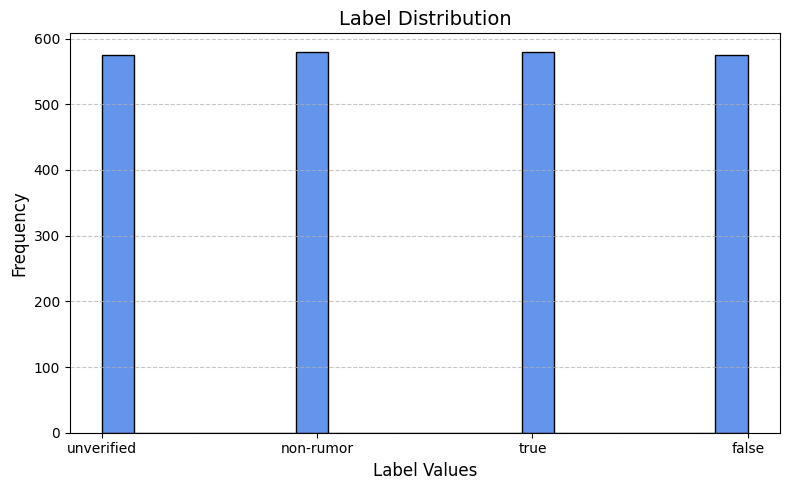

In [23]:
plt.figure(figsize=(8, 5)) 
plt.hist(tw1516_data["label"], bins=20, edgecolor="black", color="cornflowerblue")
# Title and labels 
plt.title("Label Distribution", fontsize=14)
plt.xlabel("Label Values", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show plot
plt.tight_layout()
plt.show()

In [24]:
tw1516_data.isnull().sum()/len(tw1516_data)

ID                0.0
text              0.0
label             0.0
parent_tid        0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
dtype: float64

In [25]:
tw1516_data['text'][2305]

'“after school satan clubs”? URL'

In [26]:
def clean_and_shorten_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Reconstruct split characters into proper words (e.g., "t h e" → "the")
    text = re.sub(r'\b(?:\w\s)+\w\b', lambda match: ''.join(match.group().split()), text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove the word "url" explicitly
    text = text.replace("url", "")  # Remove "url" word
    return text

In [27]:
# Apply the updated function to the dataset
tw1516_data['text_cleaned'] = tw1516_data['text'].apply(lambda x: clean_and_shorten_text(x))

# Preview the results
print(tw1516_data[['text', 'text_cleaned']].head())

                                                text  \
0  🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...   
1  an open letter to trump voters from his top st...   
2  america is a nation of second chances —@potus ...   
3  brandon marshall visits and offers advice, sup...   
4  rip elly may clampett: so sad to learn #beverl...   

                                        text_cleaned  
0  ca kkk grand wizard endorses hillaryclinton ne...  
1  an open letter to trump voters from his top st...  
2  america is a nation of second chances potus on...  
3  brandon marshall visits and offers advice supp...  
4  rip elly may clampett so sad to learn beverlyh...  


In [28]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def tokenize_and_filter(text):
    words = word_tokenize(text)
    return [word for word in words if word not in stop_words and word != "url"]

df_copy = tw1516_data.copy()

#Tokenize it
df_copy['tokens'] = df_copy['text_cleaned'].apply(tokenize_and_filter)

# Count the words
all_tokens = [token for sublist in df_copy['tokens'] for token in sublist]  # Flatten the list of tokens
word_freq = Counter(all_tokens)  # Count word frequencies

#top 10 words
most_common_words = word_freq.most_common(10)
print(most_common_words)

[('police', 139), ('shot', 111), ('says', 102), ('ferguson', 92), ('breaking', 89), ('new', 86), ('us', 85), ('trump', 82), ('paul', 82), ('obama', 82)]


[nltk_data] Downloading package punkt to /home/gigli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gigli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


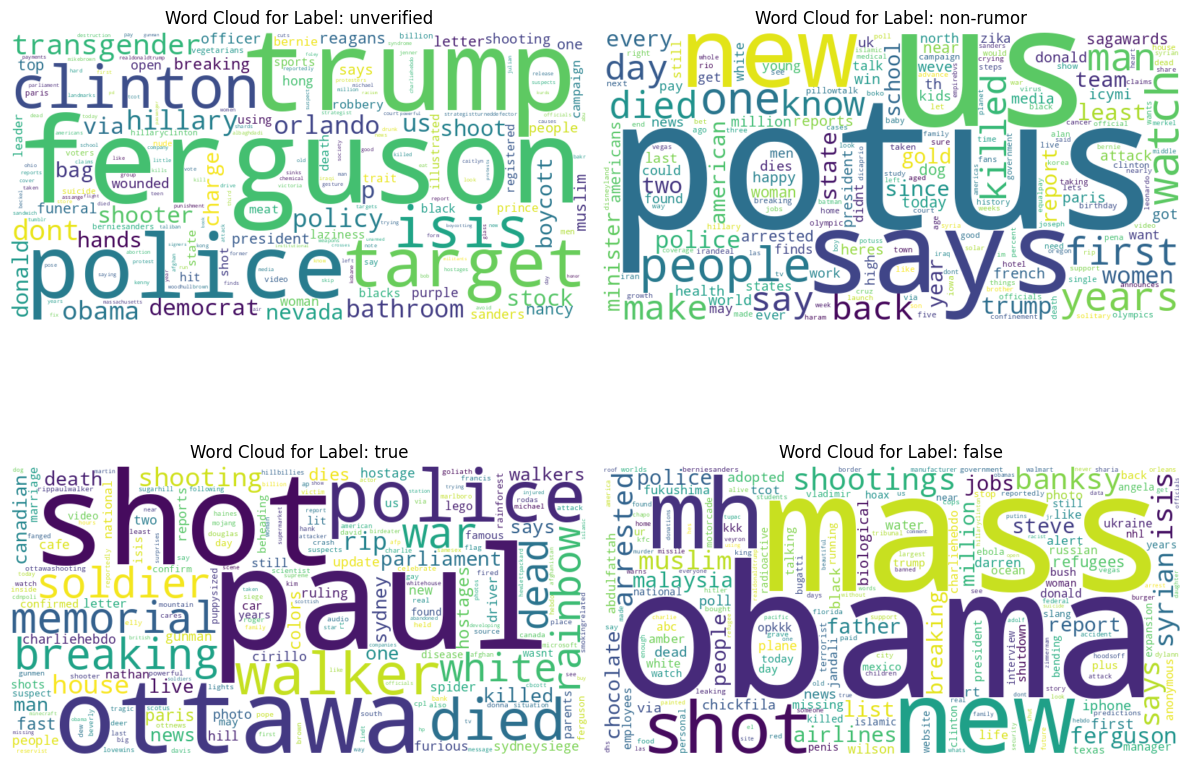

In [29]:
# Filering unique labels
unique_labels = df_copy['label'].unique()

# Create a 2x2 subplot 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten axes 
axes = axes.flatten()

# Generate and plot word clouds for each label
for i, label in enumerate(unique_labels[:4]):  # Ensure we only take up to 4 labels
    # Filter data by label
    label_data = df_copy[df_copy['label'] == label]
    
    # Flatten the list of tokens for the current label
    all_tokens = [token for sublist in label_data['tokens'] for token in sublist]
    
    # Count word frequencies for the current label
    word_freq = Counter(all_tokens)
    
    # Generate the word cloud for the current label
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the word cloud in the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f"Word Cloud for Label: {label}", fontsize=12)

# Hide any unused subplots if fewer than 4 labels
for j in range(len(unique_labels), 4):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [30]:
def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return " ".join(hashtags) if hashtags else "no hashtag"
def extract_mentions(text):
    mentions = re.findall(r'@(\w+)', text)
    return " ".join(mentions) if mentions else "no mention"

tw1516_data['hashtags'] = tw1516_data['text'].apply(extract_hashtags)
tw1516_data['mentions'] = tw1516_data['text'].apply(extract_mentions)

tw1516_data

,ID,text,label,parent_tid,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid,text_cleaned,hashtags,mentions
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,731166399389962242,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton
1,714598641827246081,an open letter to trump voters from his top st...,unverified,714598641827246081,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989,an open letter to trump voters from his top st...,no hashtag,xojanedotcom
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,691809004356501505,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925,america is a nation of second chances potus on...,no hashtag,potus
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,693204708933160960,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521,brandon marshall visits and offers advice supp...,no hashtag,no mention
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,551099691702956032,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,693546915892428800,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,544269749405097984,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661,breaking live coverage of hostage situation un...,no hashtag,no mention
2305,760109079133990912,“after school satan clubs”? URL,unverified,760109079133990912,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327,after school satan clubs,no hashtag,no mention
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,779633844680962048,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674,this network of tunnels is from the stone age ...,no hashtag,no mention


In [31]:
tw1516_data['hashtags'].value_counts()

hashtags
no hashtag                                1629
#ferguson                                   47
#charliehebdo                               32
#mh17                                       29
#sydneysiege                                17
                                          ... 
#ferguson #hongkong #hongkongdemocracy       1
#vma #weekendbrunch                          1
#eagles                                      1
#governmentshutdown                          1
#tcot #ferguson                              1
Name: count, Length: 343, dtype: int64

In [32]:
tw1516_data['mentions'].value_counts()

mentions
no mention                       1970
potus                              39
hillaryclinton                     12
berniesanders                      10
target                              8
                                 ... 
kyliejenner kourtneykardash         1
onetoughnerd                        1
drzuhdijasser potus ffweekend       1
lilduval                            1
realpaulwalker fastfurious          1
Name: count, Length: 211, dtype: int64

In [33]:
tw1516_data.drop(['parent_tid', 'text'], inplace=True, axis=1)

In [34]:
tw1516_data

,ID,label,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid,text_cleaned,hashtags,mentions
0,731166399389962242,unverified,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton
1,714598641827246081,unverified,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989,an open letter to trump voters from his top st...,no hashtag,xojanedotcom
2,691809004356501505,non-rumor,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925,america is a nation of second chances potus on...,no hashtag,potus
3,693204708933160960,non-rumor,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521,brandon marshall visits and offers advice supp...,no hashtag,no mention
4,551099691702956032,true,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention
2304,544269749405097984,true,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661,breaking live coverage of hostage situation un...,no hashtag,no mention
2305,760109079133990912,unverified,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327,after school satan clubs,no hashtag,no mention
2306,779633844680962048,unverified,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674,this network of tunnels is from the stone age ...,no hashtag,no mention


In [35]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")


/home/gigli/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
def predict_sentiment(texts, tokenizer, model, batch_size=8, max_length=512):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device (GPU or CPU)
    
    sentiment_classes = ["negative", "neutral", "positive"]  # Sentiment classes
    results = []  # To store results
    
    # Iterate over texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches", unit="batch"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize the batch of texts
        tokens = tokenizer(
            batch_texts,
            max_length=max_length,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(device)
        
        # Perform inference with no gradient calculation
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits
            
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            
            # Get the sentiment class (max probability) and confidence
            sentiment_labels = torch.argmax(probs, dim=-1)
            confidences = torch.gather(probs, 1, sentiment_labels.unsqueeze(1)).squeeze()
        
        # Map results to sentiment class and confidence
        for label, confidence in zip(sentiment_labels, confidences):
            sentiment_class = sentiment_classes[label.item()]  # Get the corresponding sentiment class
            results.append(sentiment_class)
    
    return results

In [37]:
tw1516_data['text_cleaned'] = tw1516_data['text_cleaned'].astype(str)
tw1516_data['text_cleaned'] = tw1516_data['text_cleaned'].fillna("")
texts = tw1516_data['text_cleaned'].tolist()

tw1516_data['sentiment'] = predict_sentiment(texts, tokenizer, model, batch_size=2)

tw1516_data

Processing Batches: 100%|███████████████████████████████████████████████████████| 1154/1154 [00:06<00:00, 168.93batch/s]


,ID,label,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid,text_cleaned,hashtags,mentions,sentiment
0,731166399389962242,unverified,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton,neutral
1,714598641827246081,unverified,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989,an open letter to trump voters from his top st...,no hashtag,xojanedotcom,neutral
2,691809004356501505,non-rumor,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925,america is a nation of second chances potus on...,no hashtag,potus,neutral
3,693204708933160960,non-rumor,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521,brandon marshall visits and offers advice supp...,no hashtag,no mention,neutral
4,551099691702956032,true,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention,neutral
2304,544269749405097984,true,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661,breaking live coverage of hostage situation un...,no hashtag,no mention,neutral
2305,760109079133990912,unverified,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327,after school satan clubs,no hashtag,no mention,neutral
2306,779633844680962048,unverified,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674,this network of tunnels is from the stone age ...,no hashtag,no mention,neutral


In [38]:
# Save it 
tw1516_data.to_csv('Twitter1516clean.csv', index=False)

In [39]:
tw1516_data.isnull().sum()/len(tw1516_data)

ID                0.0
label             0.0
total_children    0.0
total_comments    0.0
avg_child_time    0.0
max_child_time    0.0
min_child_time    0.0
list_child_ids    0.0
list_child_uid    0.0
parent_uid        0.0
text_cleaned      0.0
hashtags          0.0
mentions          0.0
sentiment         0.0
dtype: float64

<h3> Data Analysis and exploration </h3>

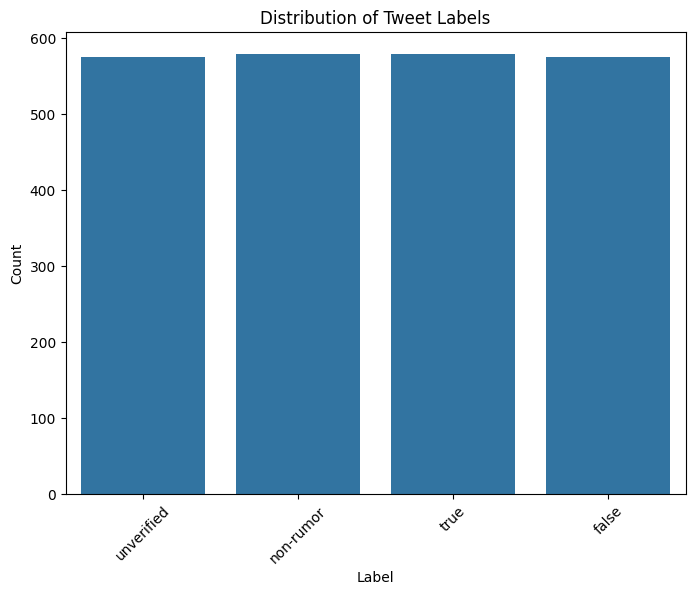

In [40]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=tw1516_data)
plt.title('Distribution of Tweet Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

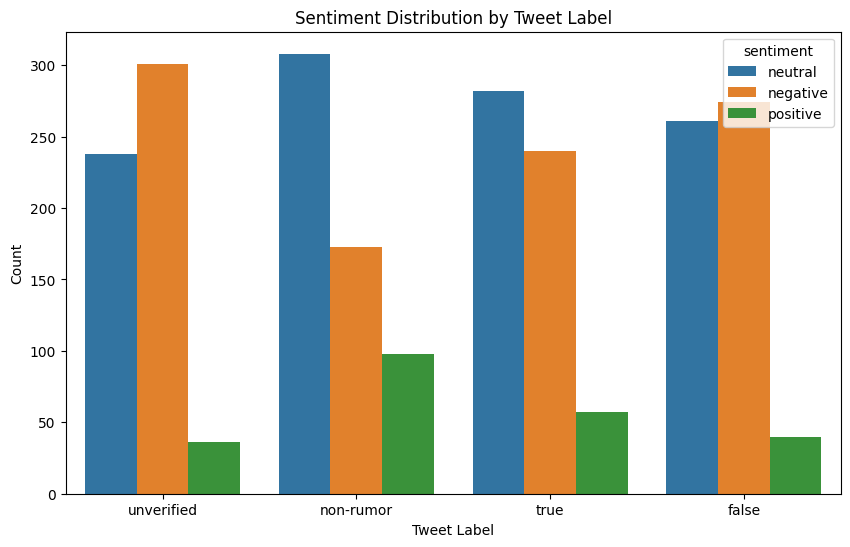

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', hue='sentiment', data=tw1516_data)
plt.title('Sentiment Distribution by Tweet Label')
plt.xlabel('Tweet Label')
plt.ylabel('Count')
plt.show()

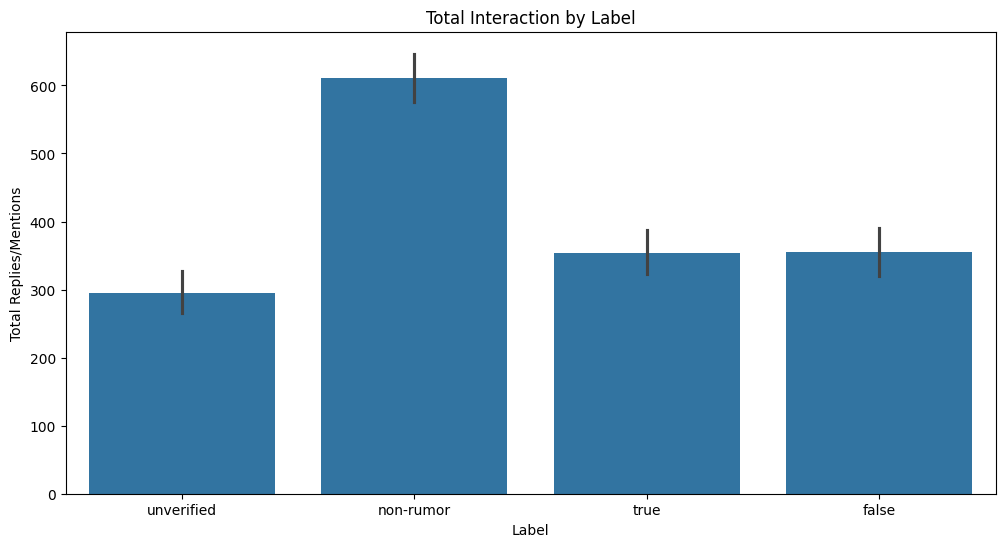

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='total_children', data=tw1516_data)
plt.title('Total Interaction by Label')
plt.xlabel('Label')
plt.ylabel('Total Replies/Mentions')
plt.show()

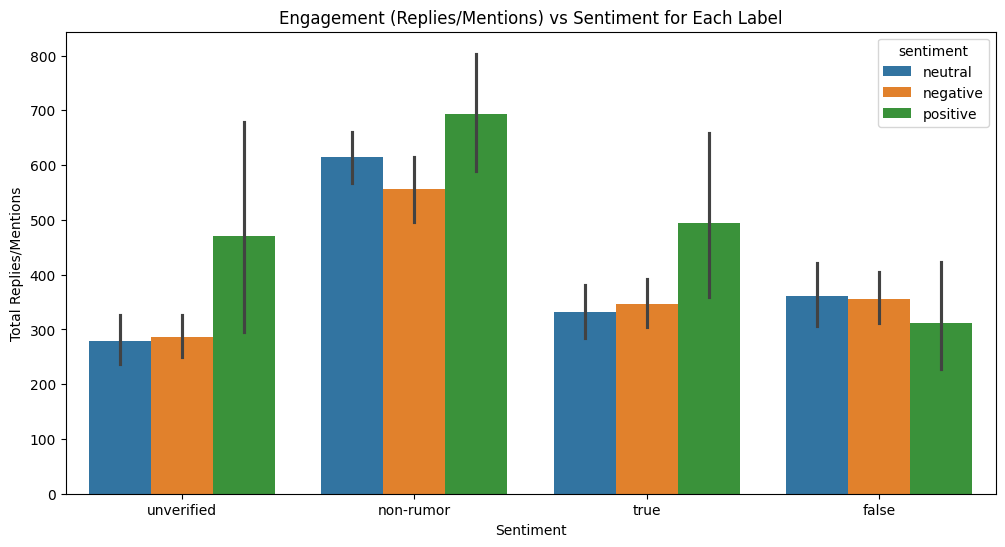

In [43]:
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='total_children', hue='sentiment', data=tw1516_data)
plt.title('Engagement (Replies/Mentions) vs Sentiment for Each Label')
plt.xlabel('Sentiment')
plt.ylabel('Total Replies/Mentions')
plt.show()

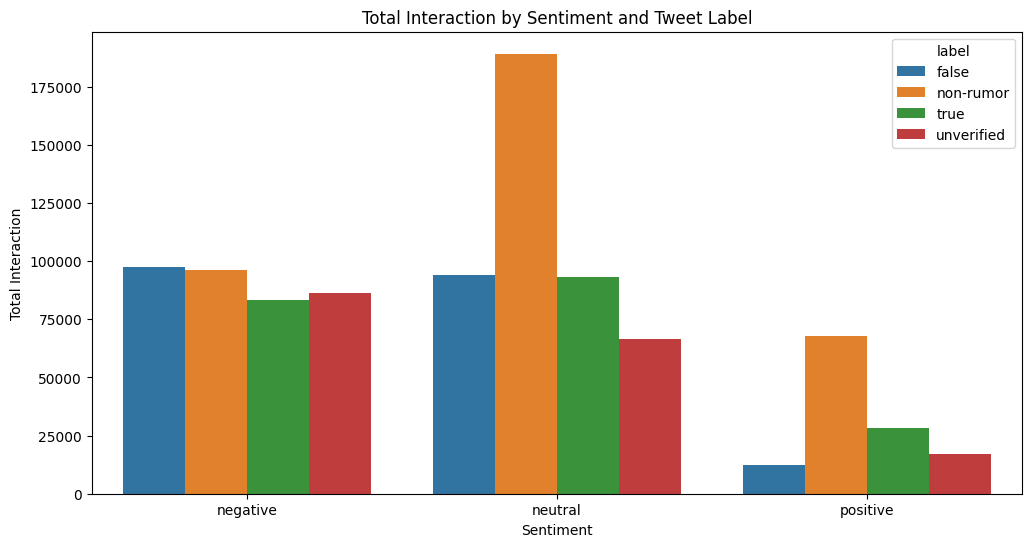

In [44]:
# Group by 'sentiment' and 'label' and calculate the sum of 'total_children'
replies_by_sentiment_label = tw1516_data.groupby(['sentiment', 'label'])['total_children'].sum().reset_index()

# Plot the total replies by sentiment and label
plt.figure(figsize=(12, 6))
sns.barplot(x='sentiment', y='total_children', hue='label', data=replies_by_sentiment_label)
plt.title('Total Interaction by Sentiment and Tweet Label')
plt.xlabel('Sentiment')
plt.ylabel('Total Interaction')
plt.show()

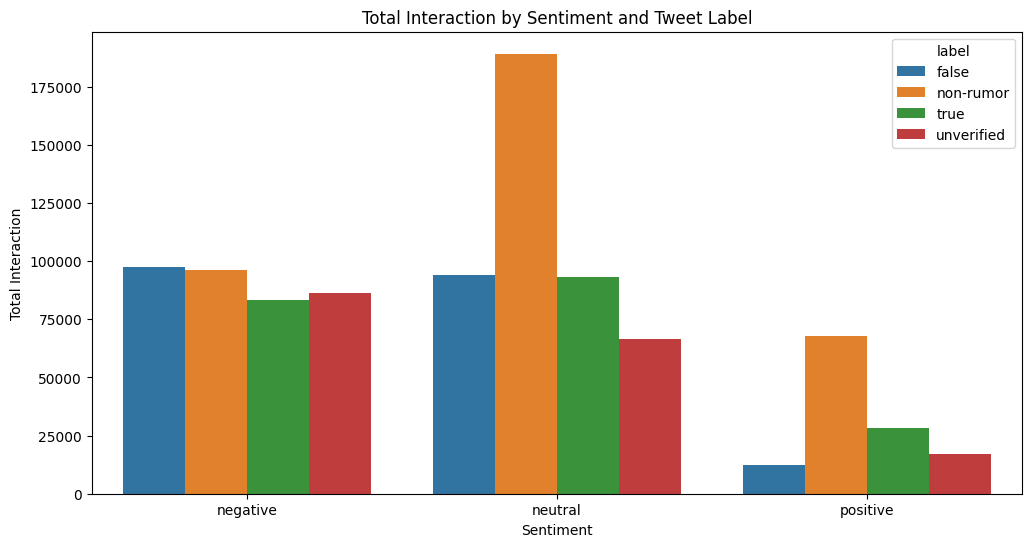

In [45]:
# Group by 'sentiment' and 'label' and calculate the sum of 'total_children'
replies_by_sentiment_label = tw1516_data.groupby(['sentiment', 'label'])['total_children'].sum().reset_index()

# Plot the total replies by sentiment and label
plt.figure(figsize=(12, 6))
sns.barplot(x='sentiment', y='total_children', hue='label', data=replies_by_sentiment_label)
plt.title('Total Interaction by Sentiment and Tweet Label')
plt.xlabel('Sentiment')
plt.ylabel('Total Interaction')
plt.show()

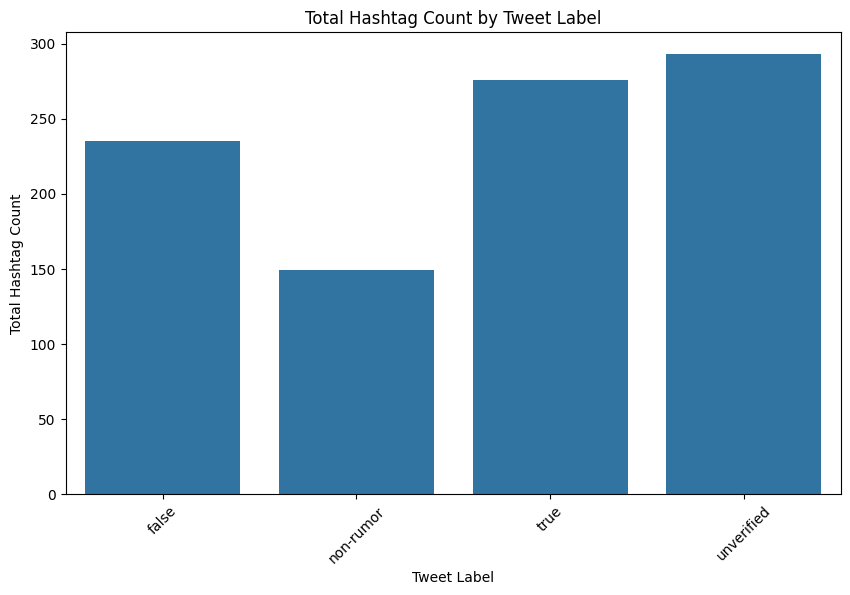

In [46]:
# Hashtag Count 
tw1516_data['hashtag_count'] = tw1516_data['hashtags'].apply(lambda x: len(x.split()) if x != 'no hashtag' else 0)

# groupby
hashtag_counts_by_label = tw1516_data.groupby('label')['hashtag_count'].sum().reset_index()

# Plot the total hashtag count by label
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='hashtag_count', data=hashtag_counts_by_label)
plt.title('Total Hashtag Count by Tweet Label')
plt.xlabel('Tweet Label')
plt.ylabel('Total Hashtag Count')
plt.xticks(rotation=45)
plt.show()

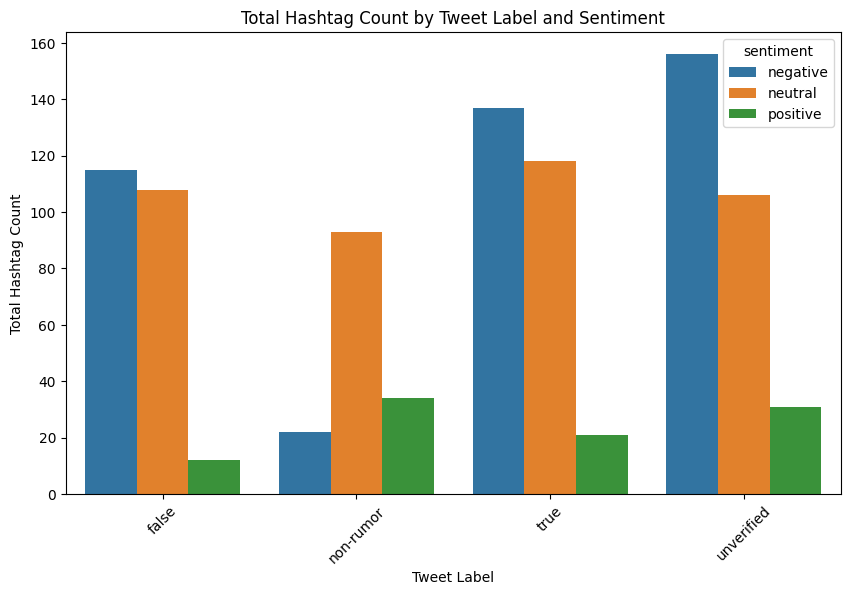

In [47]:
hashtag_counts_by_label_sentiment = tw1516_data.groupby(['label', 'sentiment'])['hashtag_count'].sum().reset_index()

# Plot the total hashtag count by label and sentiment using hue for sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='hashtag_count', hue='sentiment', data=hashtag_counts_by_label_sentiment)
plt.title('Total Hashtag Count by Tweet Label and Sentiment')
plt.xlabel('Tweet Label')
plt.ylabel('Total Hashtag Count')
plt.xticks(rotation=45)
plt.show()

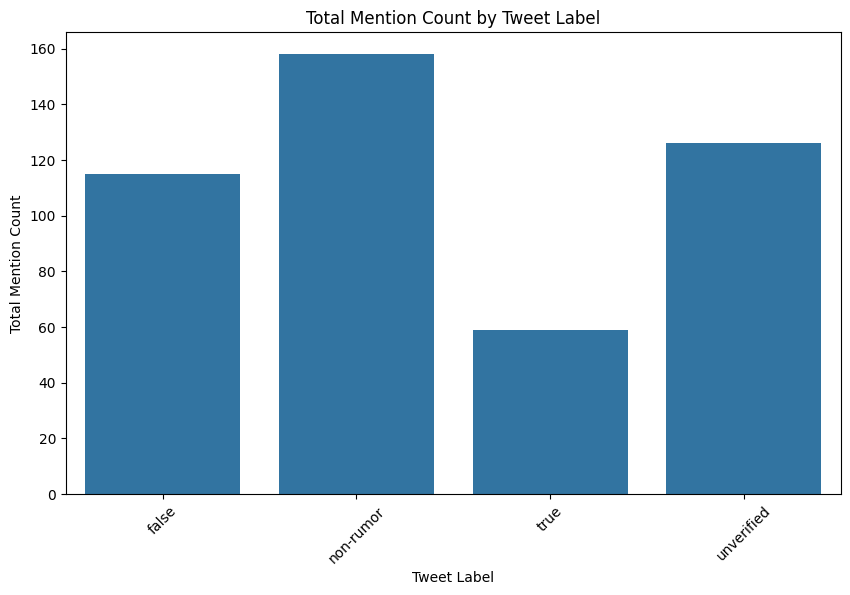

In [48]:
tw1516_data['mention_count'] = tw1516_data['mentions'].apply(lambda x: len(x.split()) if x != 'no mention' else 0)

# Group by 'label' and aggregate the total mention count by label
mention_counts_by_label = tw1516_data.groupby('label')['mention_count'].sum().reset_index()

# Plot the total mention count by label
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='mention_count', data=mention_counts_by_label)
plt.title('Total Mention Count by Tweet Label')
plt.xlabel('Tweet Label')
plt.ylabel('Total Mention Count')
plt.xticks(rotation=45)
plt.show()

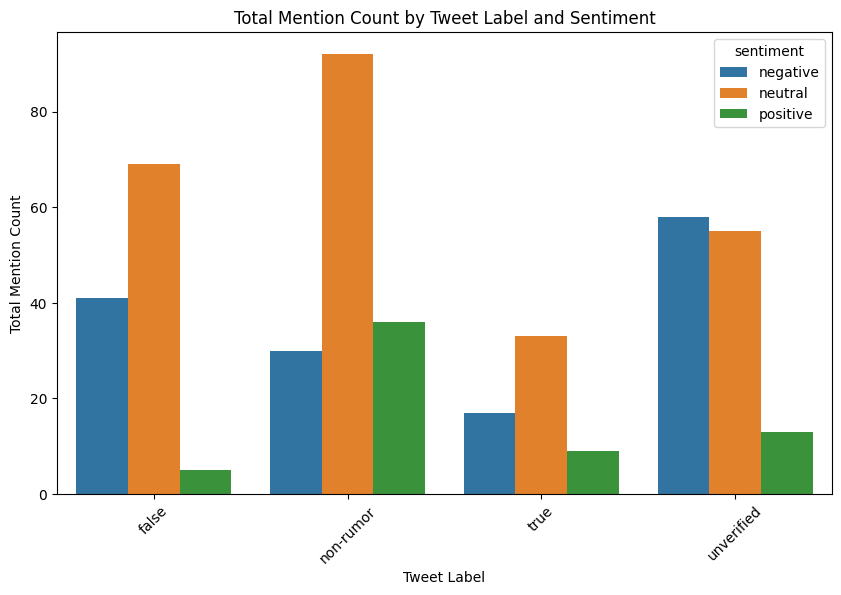

In [49]:
# Group by 'label' and 'sentiment' and calculate the sum of 'mention_count'
mention_counts_by_label_sentiment = tw1516_data.groupby(['label', 'sentiment'])['mention_count'].sum().reset_index()

# Plot the total mention count by label and sentiment using hue for sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='mention_count', hue='sentiment', data=mention_counts_by_label_sentiment)
plt.title('Total Mention Count by Tweet Label and Sentiment')
plt.xlabel('Tweet Label')
plt.ylabel('Total Mention Count')
plt.xticks(rotation=45)
plt.show()

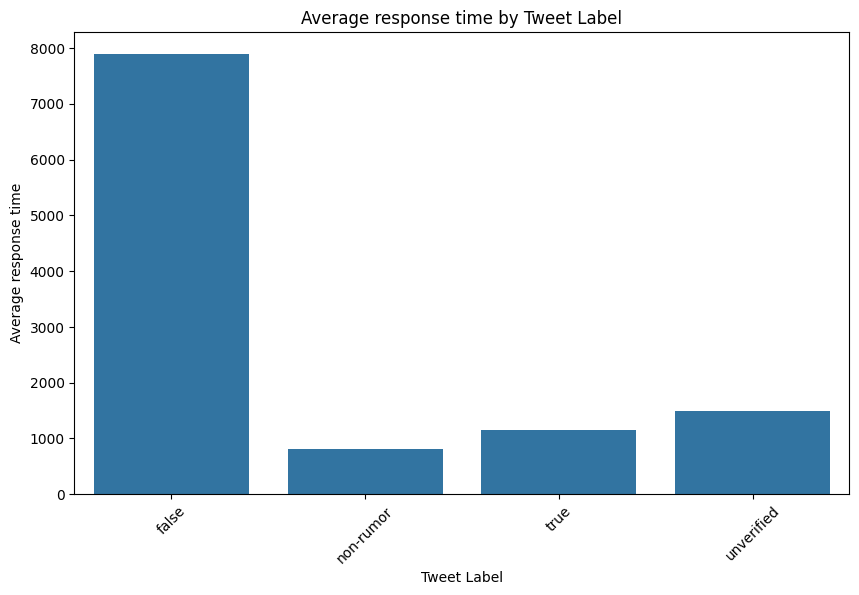

In [50]:
# Group by 'label' and calculate the average of 'avg_child_time'
avg_child_time_by_label = tw1516_data.groupby('label')['avg_child_time'].mean().reset_index()

# Plot the average child time by label
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='avg_child_time', data=avg_child_time_by_label)
plt.title('Average response time by Tweet Label')
plt.xlabel('Tweet Label')
plt.ylabel('Average response time')
plt.xticks(rotation=45)
plt.show()

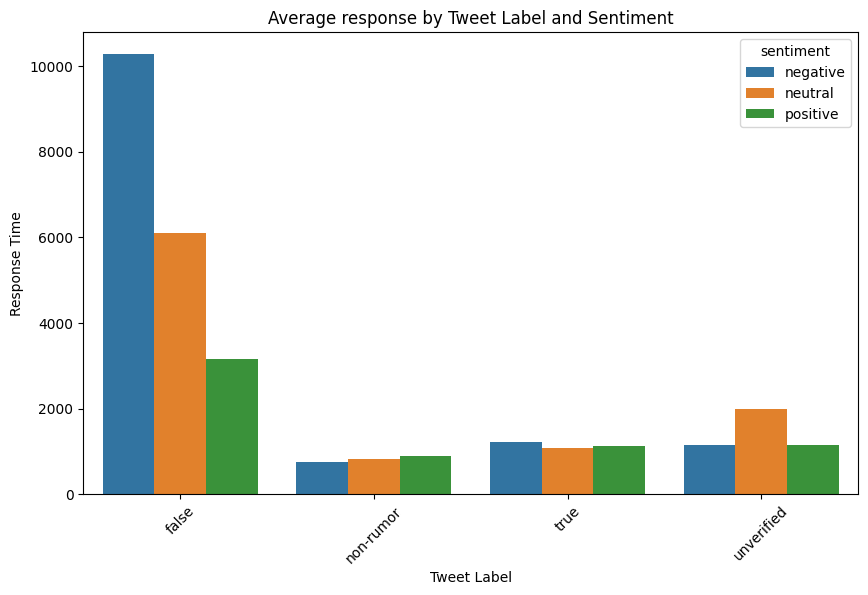

In [51]:
# Group by 'label' and 'sentiment' and calculate the average of 'avg_child_time'
avg_child_time_by_label_sentiment = tw1516_data.groupby(['label', 'sentiment'])['avg_child_time'].mean().reset_index()

# Plot the average child time by label and sentiment using hue for sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='avg_child_time', hue='sentiment', data=avg_child_time_by_label_sentiment)
plt.title('Average response by Tweet Label and Sentiment')
plt.xlabel('Tweet Label')
plt.ylabel('Response Time')
plt.xticks(rotation=45)
plt.show()

<h3> Data Preparation </h3>
<h5> Bert Embeddings</h5>

In [52]:
# Copy the original dataset
df_Bert= tw1516_data.copy()
df_Bert

,ID,label,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid,text_cleaned,hashtags,mentions,sentiment,hashtag_count,mention_count
0,731166399389962242,unverified,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton,neutral,2,1
1,714598641827246081,unverified,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989,an open letter to trump voters from his top st...,no hashtag,xojanedotcom,neutral,0,1
2,691809004356501505,non-rumor,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925,america is a nation of second chances potus on...,no hashtag,potus,neutral,0,1
3,693204708933160960,non-rumor,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521,brandon marshall visits and offers advice supp...,no hashtag,no mention,neutral,0,0
4,551099691702956032,true,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention,negative,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,693546915892428800,non-rumor,289,289,626.303806,21791.77,0.35,"[693546915892428800, 693547140405186560, 69354...","[2816185536, 21127363, 78701299, 365330063, 15...",14075928,jeb bush campaign kicks off state farewell tou...,no hashtag,no mention,neutral,0,0
2304,544269749405097984,true,441,441,64.466871,1110.08,0.22,"[544269749405097984, 544272301416775680, 54427...","[73106978, 24820089, 40138389, 545642497, 2905...",15250661,breaking live coverage of hostage situation un...,no hashtag,no mention,neutral,0,0
2305,760109079133990912,unverified,147,147,652.671156,24738.58,1.20,"[760109079133990912, 760109451856715777, 76010...","[933294247, 17138821, 349461319, 26596157, 746...",44945327,after school satan clubs,no hashtag,no mention,neutral,0,0
2306,779633844680962048,unverified,472,472,5799.563326,26430.47,0.75,"[779634034859249666, 779633844680962048, 77963...","[2885555216, 1547943294, 745761578054615040, 1...",918346674,this network of tunnels is from the stone age ...,no hashtag,no mention,neutral,0,0


In [53]:
# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  #Using GPU
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings


/home/gigli/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly ident

In [55]:
texts = df_Bert['text_cleaned'].tolist()
embeddings = get_bert_embeddings(texts)

In [56]:
#Move back do CPU for visualization
sentence_embeddings = embeddings.mean(dim=1).squeeze().cpu().numpy() 

df_Bert['bert_embeddings'] = list(sentence_embeddings)

print(df_Bert[['text_cleaned', 'bert_embeddings']].head())

                                        text_cleaned  \
0  ca kkk grand wizard endorses hillaryclinton ne...   
1  an open letter to trump voters from his top st...   
2  america is a nation of second chances potus on...   
3  brandon marshall visits and offers advice supp...   
4  rip elly may clampett so sad to learn beverlyh...   

                                     bert_embeddings  
0  [-0.095595814, -0.06573972, 0.6080362, 0.27787...  
1  [-0.053521287, -0.1904636, 0.29958516, 0.24643...  
2  [-0.0638172, -0.12853184, 0.26268712, 0.191746...  
3  [-0.18802927, -0.021748897, 0.024089186, 0.260...  
4  [-0.32250586, -0.12949431, 0.3775044, -0.24595...  


<H3> Machine Learning Models </H3>

In [57]:
# Check data
df_Bert.head()

,ID,label,total_children,total_comments,avg_child_time,max_child_time,min_child_time,list_child_ids,list_child_uid,parent_uid,text_cleaned,hashtags,mentions,sentiment,hashtag_count,mention_count,bert_embeddings
0,731166399389962242,unverified,145,145,14869.900345,171903.50,7.18,"[731168205788471297, 731166399389962242, 73117...","[21107092, 4318345394, 26538104, 2906655619, 9...",431917957,ca kkk grand wizard endorses hillaryclinton ne...,#neverhillary #trump2016,hillaryclinton,neutral,2,1,"[-0.095595814, -0.06573972, 0.6080362, 0.27787..."
1,714598641827246081,unverified,94,94,1485.355638,101483.42,3.53,"[714598641827246081, 714601867607740416, 71460...","[14754392, 14170609, 27979317, 22785979, 16159...",94215989,an open letter to trump voters from his top st...,no hashtag,xojanedotcom,neutral,0,1,"[-0.053521287, -0.1904636, 0.29958516, 0.24643..."
2,691809004356501505,non-rumor,629,629,900.127234,27374.98,1.98,"[691809004356501505, 691809522533449728, 69181...","[15549482, 2612905670, 1013386932, 834672494, ...",30313925,america is a nation of second chances potus on...,no hashtag,potus,neutral,0,1,"[-0.0638172, -0.12853184, 0.26268712, 0.191746..."
3,693204708933160960,non-rumor,324,324,758.480123,14027.32,0.40,"[693204708933160960, 693204917142425600, 69320...","[17824832, 344433558, 30866511, 299374041, 605...",2557521,brandon marshall visits and offers advice supp...,no hashtag,no mention,neutral,0,0,"[-0.18802927, -0.021748897, 0.024089186, 0.260..."
4,551099691702956032,true,116,116,33.907759,610.92,0.20,"[551099744441741313, 551099691702956032, 55110...","[780992342, 784659810, 962684082, 20953256, 26...",2883841,rip elly may clampett so sad to learn beverlyh...,#beverlyhillbillies,no mention,negative,1,0,"[-0.32250586, -0.12949431, 0.3775044, -0.24595..."


In [58]:
# Encode label & sentiment
label_encoder = LabelEncoder()
df_Bert['sentiment_encoded'] = label_encoder.fit_transform(df_Bert['sentiment'])
y = label_encoder.fit_transform(df_Bert['label'])

In [59]:
#Move Bert embeddings into a list
X_bert = np.array(df_Bert['bert_embeddings'].tolist())
# Gather aditional features
additional_features = df_Bert[['hashtag_count', 'mention_count', 'total_children', 'avg_child_time', 'max_child_time', 'min_child_time','sentiment_encoded']].values

# Scale the additional features 
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

# Combine the features
X_combined = np.hstack([X_bert, additional_features_scaled])  



len(X_combined)

2308

In [60]:
# Split the data into Train and temp 
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.20, random_state=33, stratify=y)

# Split temp Data into Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)

# Confirm Shapes
print(f" X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

 X_train shape: (1846, 775), y_train shape: (1846,)
X_val shape: (231, 775), y_val shape: (231,)
X_test shape: (231, 775), y_test shape: (231,)


<h5> Support Vector Machine (SVM) </h5>

In [61]:
# Parameters for SVM 
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr']
}

In [62]:
# Grid search
grid_search_svm = GridSearchCV(SVC(random_state=33), param_grid_svm, cv=3, verbose=1, n_jobs=4)
grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=SVC(random_state=33), n_jobs=4,
             param_grid={'C': [0.1, 1, 10],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [63]:
# Best parameters
best_svm_model = grid_search_svm.best_estimator_
print(f"Best Parameters for SVM: {grid_search_svm.best_params_}")

Best Parameters for SVM: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


In [64]:
# Predict on the Validation Set
y_val_preds_svm = best_svm_model.predict(X_val)

# Compute Validation Accuracy
val_accuracy = accuracy_score(y_val, y_val_preds_svm)
print(f"\n GridSearch SVM Validation Accuracy: {val_accuracy:.4f}")


 GridSearch SVM Validation Accuracy: 0.8268


In [65]:
# Predict on the Test Set
y_test_preds_svm = best_svm_model.predict(X_test)

# Compute Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_preds_svm)
print(f"\n GridSearch SVM Test Accuracy: {test_accuracy:.4f}")

# Reverse the encoding (convert numbers back to original labels)
y_test_original = label_encoder.inverse_transform(y_test) 
y_test_preds_original = label_encoder.inverse_transform(y_test_preds_svm)  

# Print Classification Report for Test Set
print("\n Classification Report for GridSearch SVM (Test Set):")
print(classification_report(y_test_original, y_test_preds_original))


 GridSearch SVM Test Accuracy: 0.8268

 Classification Report for GridSearch SVM (Test Set):
              precision    recall  f1-score   support

       false       0.80      0.76      0.78        58
   non-rumor       0.83      0.83      0.83        58
        true       0.89      0.93      0.91        58
  unverified       0.79      0.79      0.79        57

    accuracy                           0.83       231
   macro avg       0.83      0.83      0.83       231
weighted avg       0.83      0.83      0.83       231



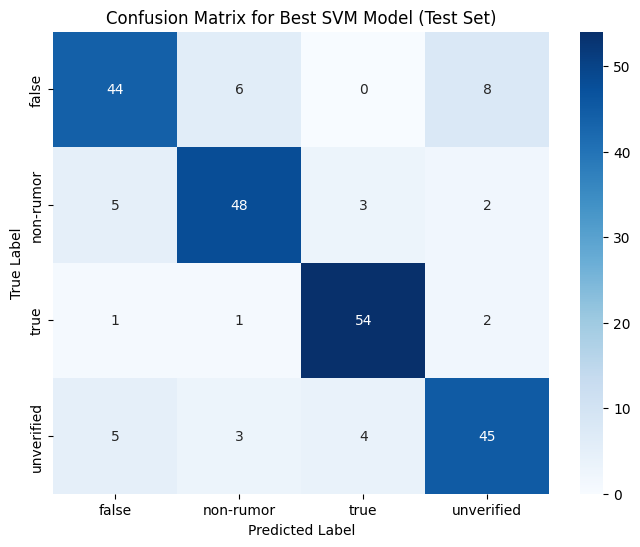

In [66]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_test_preds_original)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= label_encoder.classes_, yticklabels=label_encoder.classes_) 
plt.title("Confusion Matrix for Best SVM Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h5> XGBoost </h5>

In [67]:
# Hyper Parameters for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'objective': ['multi:softmax'],
    'num_class': [len(label_encoder.classes_)]
}

In [68]:
# Performing Grid-search
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(eval_metric='mlogloss'), param_grid_xgb, cv=3, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200], 'num_class': [4],
                         'objective': ['multi:softmax']},
             verbose=1)

In [69]:
# Best hyperparameters
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")

Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'num_class': 4, 'objective': 'multi:softmax'}


In [70]:
# Predict on Validation Set
y_val_preds_xgb = best_xgb_model.predict(X_val)

# Compute Validation Accuracy
val_accuracy = accuracy_score(y_val, y_val_preds_xgb)
print(f"\n GridSearch XGBoost Validation Accuracy: {val_accuracy:.4f}")



 GridSearch XGBoost Validation Accuracy: 0.7489


In [71]:
# Predict on the Test Set
y_test_preds_xgb = best_xgb_model.predict(X_test)

# Compute Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_preds_xgb)
print(f"\n GridSearch XGBoost Test Accuracy: {test_accuracy:.4f}")

y_test_original = label_encoder.inverse_transform(y_test) 
y_test_preds_original_xgb = label_encoder.inverse_transform(y_test_preds_xgb)  

# Print Classification Report for Test Set
print("\n Classification Report for GridSearch XGBoost (Test Set):")
print(classification_report(y_test_original, y_test_preds_original_xgb))


 GridSearch XGBoost Test Accuracy: 0.8009

 Classification Report for GridSearch XGBoost (Test Set):
              precision    recall  f1-score   support

       false       0.78      0.66      0.71        58
   non-rumor       0.78      0.90      0.83        58
        true       0.86      0.88      0.87        58
  unverified       0.79      0.77      0.78        57

    accuracy                           0.80       231
   macro avg       0.80      0.80      0.80       231
weighted avg       0.80      0.80      0.80       231



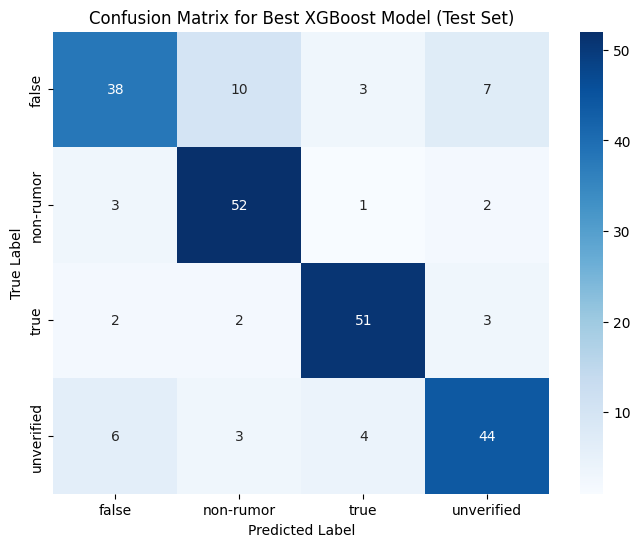

In [72]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original, y_test_preds_original_xgb)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= label_encoder.classes_, yticklabels=label_encoder.classes_) 
plt.title("Confusion Matrix for Best XGBoost Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h3> Deep Learning </h3>

In [73]:
# Transform embeddings panda series into numpy array 
X_bert = np.array([np.array(embed) for embed in df_Bert['bert_embeddings']])
#Select othe features
X_other = df_Bert[['total_children', 'avg_child_time', 'hashtag_count', 'mention_count', 'sentiment_encoded']].values

# Scale 
scaler = StandardScaler()
X_other_scaled = scaler.fit_transform(X_other)

# Combine features
X_combined = np.hstack((X_bert, X_other_scaled))


# Select values for target variable
y = df_Bert['label'].values
# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [74]:
# Split the data 
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_encoded, test_size=0.20, stratify=y_encoded, random_state=33)

# Split Remaining Data into Validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=33)

# Confirm Shapes
print(f" X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f" X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f" X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


 X_train shape: (1846, 773), y_train shape: (1846,)
 X_val shape: (231, 773), y_val shape: (231,)
 X_test shape: (231, 773), y_test shape: (231,)


<h3> Feed Forward Neural Network </h3>

In [75]:

# Define FFNN Model
class FFNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_func='relu'):
        super(FFNNModel, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        if activation_func == 'relu':
            self.activation = nn.ReLU()
        elif activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x


In [76]:

# Hyperparameter grid for tuning
param_grid = {
    'hidden_size': [64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 96],
    'num_epochs': [5, 10],
    'activation_func': ['relu', 'sigmoid']
}

# Store best hyperparameters
best_acc = 0.0
best_params = {}

# Stratified K-Fold for splitting data into train/validation
kf = KFold(n_splits=5, shuffle=True, random_state=33)# PyTorch Doesn't have inbuild CV 


# Convert data to PyTorch
X_train_tensor_full = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor_full = torch.tensor(y_train, dtype=torch.long) # Lalbels need to be in long format

In [77]:
# Manually iterating through hyperparameters
for params in ParameterGrid(param_grid):
    fold_acc = []  # Store accuracy for each fold

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        print(f"\n Fold {fold + 1}/{kf.get_n_splits()} - Testing Params: {params}")

        # Use index-based slicing
        X_train_tensor = X_train_tensor_full[train_idx]
        y_train_tensor = y_train_tensor_full[train_idx]
        X_val_tensor = X_train_tensor_full[val_idx]
        y_val_tensor = y_train_tensor_full[val_idx]

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=params['batch_size'], shuffle=False)

        # Initialize model, optimizer, and loss function
        model = FFNNModel(input_size=X_train.shape[1], hidden_size=params['hidden_size'], num_classes=len(set(y_train)), activation_func=params['activation_func']).to('cpu')
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.CrossEntropyLoss()

        # Train model
        for epoch in range(params['num_epochs']):
            model.train()
            for batch in train_loader:
                inputs, labels = [item.to('cpu') for item in batch]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = [item.to('cpu') for item in batch]
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.numpy())
                val_labels.extend(labels.numpy())

        # Compute accuracy for this fold
        val_acc = accuracy_score(val_labels, val_preds)
        fold_acc.append(val_acc)

    # Compute average accuracy across all folds
    avg_fold_acc = sum(fold_acc) / len(fold_acc)
    print(f"\n Avg Validation Accuracy for {params}: {avg_fold_acc:.4f}")

    # Store the best model based on validation accuracy
    if avg_fold_acc > best_acc:
        best_acc = avg_fold_acc
        best_params = params

# Print the best parameters
print(f"\n Best Hyperparameters Found: {best_params}")
print(f" Best Validation Accuracy: {best_acc:.4f}")


 Fold 1/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 2/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 3/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 4/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 5/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Avg Validation Accuracy for {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}: 0.6577

 Fold 1/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 10}

 Fold 2/5 - Testing Params: {'activation_func': 're

In [130]:
# Train the best FFNN model on the full training set
best_ffnn_model = FFNNModel(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'], 
                            num_classes=len(set(y_train)), activation_func=best_params['activation_func']).to('cpu')

optimizer_best = optim.Adam(best_ffnn_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

# Convert training data to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)

# Train best model
for epoch in range(best_params['num_epochs']):
    best_ffnn_model.train()
    for batch in train_loader:
        inputs, labels = [item.to('cpu') for item in batch]
        optimizer_best.zero_grad()
        outputs = best_ffnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_best.step()

In [131]:
# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create test DataLoader
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=best_params['batch_size'], shuffle=False)

# Evaluate best model on test data
best_ffnn_model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = [item.to('cpu') for item in batch]
        outputs = best_ffnn_model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.numpy())  # Append predicted class
        test_labels.extend(labels.numpy())  # Append true labels

# Compute Test Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f" Final FFNN Test Accuracy: {test_accuracy:.4f}")

 Final FFNN Test Accuracy: 0.7532


In [132]:
# Convert label to original
y_test_original_ffnn = label_encoder.inverse_transform(test_labels) 
y_test_preds_original_ffnn = label_encoder.inverse_transform(test_preds)

# Classification Report
print("Classification Report for Best FFNN Model:")
print(classification_report(y_test_original_ffnn , y_test_preds_original_ffnn ))

Classification Report for Best FFNN Model:
              precision    recall  f1-score   support

       false       0.67      0.66      0.66        58
   non-rumor       0.82      0.72      0.77        58
        true       0.75      0.90      0.82        58
  unverified       0.78      0.74      0.76        57

    accuracy                           0.75       231
   macro avg       0.76      0.75      0.75       231
weighted avg       0.76      0.75      0.75       231



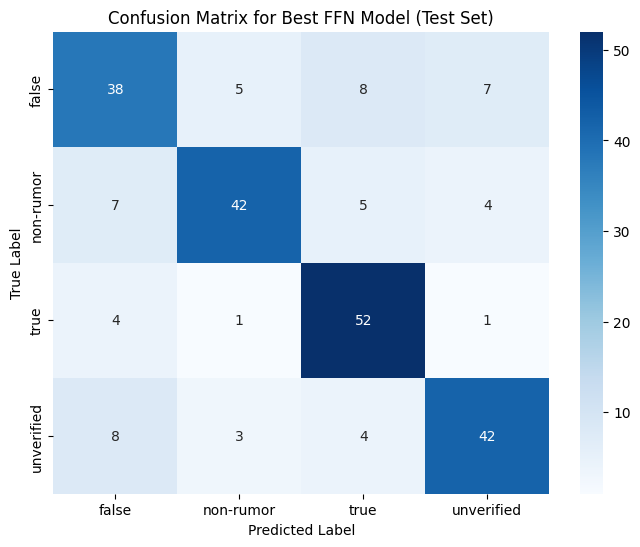

In [133]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original_ffnn, y_test_preds_original_ffnn)
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= label_encoder.classes_, yticklabels=label_encoder.classes_) 
plt.title("Confusion Matrix for Best FFN Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




<h3> Recurrent Neural Network </h3>

In [82]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_func='relu', dropout_rate=0.3):
        super(RNNModel, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)  # Ensure dropout is used

        # Choose activation function
        if activation_func == 'relu':
            self.activation = nn.ReLU()
        elif activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()


    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        rnn_out = rnn_out[:, -1, :]  # Take last output
        out = self.fc1(rnn_out)
        out = self.activation(out)
        out = self.dropout(out)  # Apply dropout
        out = self.fc2(out)
        return out


In [83]:
# Convert dataset to PyTorch since RNN needs 3D data
X_train_tensor_full = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (batch_size, seq_len=1, input_size)
#
y_train_tensor_full = torch.tensor(y_train, dtype=torch.long)


# Hyperparameter tunning 
param_grid = {
    'hidden_size': [64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 96],
    'num_epochs': [5, 10],
    'activation_func': ['relu', 'sigmoid'],
    'dropout_rate': [0.3, 0.5] 
}

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=33)
best_acc= 0.0
best_params = {}


In [84]:
for params in ParameterGrid(param_grid):
    fold_acc = []  # Store accuracy for each fold

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        print(f"\n Fold {fold + 1}/{kf.get_n_splits()} - Testing Params: {params}")

        # Use index-based slicing
        X_train_tensor = X_train_tensor_full[train_idx]
        y_train_tensor = y_train_tensor_full[train_idx]
        X_val_tensor = X_train_tensor_full[val_idx]
        y_val_tensor = y_train_tensor_full[val_idx]

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=params['batch_size'], shuffle=False)

        # Initialize model, optimizer, and loss function
        model = RNNModel(input_size=X_train.shape[1], hidden_size=params['hidden_size'], num_classes=len(set(y_train)), activation_func=params['activation_func'], dropout_rate=params['dropout_rate']).to('cpu')
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.CrossEntropyLoss()

        # Train model
        for epoch in range(params['num_epochs']):
            model.train()
            for batch in train_loader:
                inputs, labels = [item.to('cpu') for item in batch]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = [item.to('cpu') for item in batch]
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.numpy())
                val_labels.extend(labels.numpy())

        # Compute accuracy for this fold
        val_acc = accuracy_score(val_labels, val_preds)
        fold_acc.append(val_acc)

    # Compute average accuracy across all folds
    avg_fold_acc = sum(fold_acc) / len(fold_acc)
    print(f"\n Avg Validation Accuracy for {params}: {avg_fold_acc:.4f}")

    # Store the best model based on validation accuracy
    if avg_fold_acc > best_acc:
        best_acc = avg_fold_acc
        best_params = params

# Print the best parameters
print(f"\n Best Hyperparameters Found: {best_params}")
print(f" Best Validation Accuracy: {best_acc:.4f}")


 Fold 1/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 2/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 3/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 4/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Fold 5/5 - Testing Params: {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}

 Avg Validation Accuracy for {'activation_func': 'relu', 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 5}: 0.6018

 Fold 1/5 - Testing Params: {'activation_func': 'relu', 'bat

In [89]:
# Train the best RNN model on the full training set
best_rnn_model = RNNModel(input_size=X_train.shape[1], hidden_size=best_params['hidden_size'], 
                          num_classes=len(set(y_train)), activation_func=best_params['activation_func'], dropout_rate=best_params['dropout_rate']).to('cpu')

optimizer_best = optim.Adam(best_rnn_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

# Convert training data to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)

# Train best model
for epoch in range(best_params['num_epochs']):
    best_rnn_model.train()
    for batch in train_loader:
        inputs, labels = [item.to('cpu') for item in batch]
        optimizer_best.zero_grad()
        outputs = best_rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_best.step()


In [90]:
# Ensure test data is 3D for RNN
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create test DataLoader
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=best_params['batch_size'], shuffle=False)

# Evaluate best model on test data
best_rnn_model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = [item.to('cpu') for item in batch]
        outputs = best_rnn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())


# Test Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f" Final RNN Test Accuracy: {test_accuracy:.4f}")

 Final RNN Test Accuracy: 0.7489


In [91]:
# Back to original labels
y_test_original_rnn = label_encoder.inverse_transform(test_labels) 
y_test_preds_original_rnn = label_encoder.inverse_transform(test_preds)

# Classification Report
print("Classification Report for Best RNN Model:")
print(classification_report(y_test_original_rnn  , y_test_preds_original_rnn ))

Classification Report for Best RNN Model:
              precision    recall  f1-score   support

       false       0.69      0.69      0.69        58
   non-rumor       0.85      0.71      0.77        58
        true       0.88      0.79      0.84        58
  unverified       0.63      0.81      0.71        57

    accuracy                           0.75       231
   macro avg       0.76      0.75      0.75       231
weighted avg       0.77      0.75      0.75       231



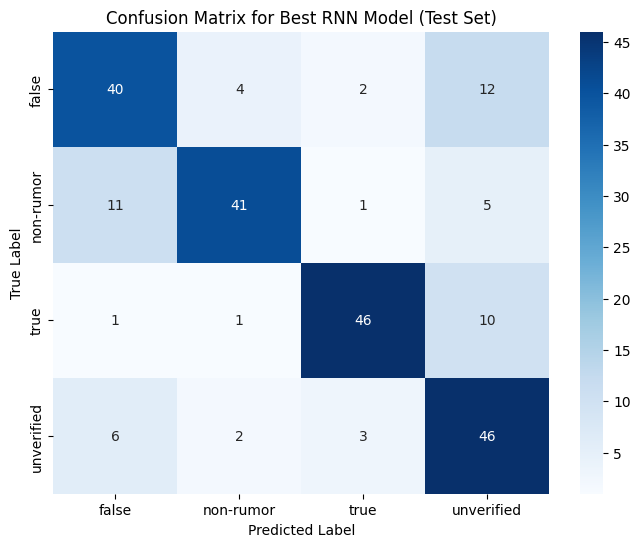

In [92]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_original_rnn, y_test_preds_original_rnn )
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= label_encoder.classes_, yticklabels=label_encoder.classes_) 
plt.title("Confusion Matrix for Best RNN Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



<H3> References: </H3>

- https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

- https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

- https://medium.com/biased-algorithms/cross-validation-in-pytorch-2f9f9fa9ab16

- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

- https://medium.com/@abhinav.mishra123/building-a-recurrent-neural-network-rnn-with-pytorch-9358a696d7dc